This project was intended to be done by Pycharm but due to technical difficulties and need for fast training by GPU, its development was moved to Google Colaboratory.

The cell below asks you to mount your google drive in order to save the outputs as a downloadable file.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In the cell below, all the packages and classes needed are imported.

In [2]:
import torch
import torch.nn as net
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms as tf, datasets as ds
from torch.optim.lr_scheduler import StepLR

In the cell below, the network class is implemented. This class extends torch.nn.Module, as all neural networks in pytorch should inherit this class in order to function as desired.
The overall information about the network comes in comments and details come in a pdf file.

In [3]:
class Brain(net.Module): #inherits nn.Module

    def __init__(self):
        super(Brain, self).__init__()

        #gets one photo (acting as one feature map) as input, outputs 64 feature maps by using 3x3 convolution with stride 1.
        self.conv1 = net.Conv2d(1, 64, 3, 1)

        self.conv2 = net.Conv2d(64, 128, 3, 1) #gets the 64 feature maps as input, outputs 128 feature maps by using 3x3 convolution with stride 1.
        
        #Dropout technique with probability of each node's prescence in training = 0.25 and 0.5,in order to get more accurate network,
        #less prone to overfitting. 
        self.dropout1 = net.Dropout2d(0.25) 
        self.dropout2 = net.Dropout2d(0.5)

        #Two fully connected layers for classification. 18432 is the number of params after doing the second convolution. 
        self.fc1 = net.Linear(18432, 256)
        self.fc2 = net.Linear(256, 10)

    def forward(self, x): #Applying convolutions and actications one by one.
       x = self.conv1(x) #First convolution
       x = F.relu(x) #Activation function
       x = self.conv2(x) #Second convolution
       x = F.relu(x) #Activation function
       x = F.max_pool2d(x, 2) #Max pool with stride 2 and kernel size 2.
       x = self.dropout1(x) #Dropout for more accuracy in classification and faster training
       x = x.view(x.size(0), -1) #Fully connected layers get a one dimentional output. So we have to flatten their inputs, if needed.
       x = self.fc1(x) #Applying first one for classification
       x = F.relu(x) #Activation function for classification
       x = self.dropout2(x) #Dropout for more accuracy in classification and faster training
       x = self.fc2(x) #Final classification, 10 outputs (as we have 10 digits)
       output = F.log_softmax(x, 1) #One dimentional LogSoftmax, better numerical performance.
       return output


In the cell below, we load the dataset. This function downloads the dataset, transforms it to tensors, normalizes it (the normalization std and mean are the global mean and std of MNIST dataset) and shuffles it. Train and test phases are also separated.
 
Inputs:
1. root - where the data should be loaded
2. batch_size - size of each mini-batch for SGD.
3. phase - indicates whether loading the test or the training data
4. dataset_name - name of the dataset to be loaded. Default: MNIST
5. shuffle - whether shuffling the dataset or not. Used in order to avoid possible overfitting.

Output:
* Loaded data.

Raises exceptions if the dataset is not defined for loading, or entering a phase any other than train or test.








In [4]:
def load_data(root, batch_size, phase, dataset_name='MNIST', shuffle=True):

    if dataset_name == 'MNIST':

        if phase == 'train':
            transform = tf.Compose([tf.ToTensor(), tf.Normalize((0.1307,), (0.3081,))]) #Transform dictionary.
            loaded_data = data.DataLoader(ds.MNIST(root=root, train=True, transform=transform, download=True), batch_size=batch_size, shuffle=shuffle)
            return loaded_data

        elif phase == 'test':
            transform = tf.Compose([tf.ToTensor(), tf.Normalize((0.1307,), (0.3081,))])
            loaded_data = data.DataLoader(ds.MNIST(root=root, train=False, transform=transform, download=True), batch_size=batch_size, shuffle=shuffle)
            return loaded_data

        else:
            raise Exception('You can only train me, or test me based on my training!')

    else:
        raise Exception('Sorry, I have not received training on other datasets so far.')


In [5]:
n_epochs = 50 #Epoch number.
train_batch_size = 200 #Train batch size
test_batch_size = 1000 #Test batch size
learning_rate = 0.05
momentum = 0.6
log_interval = 10 #Intervals between printing the steps in training.
random_seed = 1 #random seed for manual seed
use_cuda = True #Using cuda GPU. Do not forget to set the environment to GPU (Runtime -> Change runtime type -> Hardware accelerator -> GPU)
torch.manual_seed(random_seed) #Seeding RNG (Random Number Generator) for CPU and GPU as pytorch does not guarantee reproducible result across its releases.

train_batch = load_data('train/', train_batch_size, 'train') #Train data
test_batch = load_data('test/', test_batch_size, 'test') #Test data

Extracting train/MNIST/raw/train-images-idx3-ubyte.gz to train/MNIST/raw


Extracting train/MNIST/raw/train-labels-idx1-ubyte.gz to train/MNIST/raw


Extracting train/MNIST/raw/t10k-images-idx3-ubyte.gz to train/MNIST/raw


Extracting train/MNIST/raw/t10k-labels-idx1-ubyte.gz to train/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting test/MNIST/raw/train-images-idx3-ubyte.gz to test/MNIST/raw


Extracting test/MNIST/raw/train-labels-idx1-ubyte.gz to test/MNIST/raw


Extracting test/MNIST/raw/t10k-images-idx3-ubyte.gz to test/MNIST/raw


Extracting test/MNIST/raw/t10k-labels-idx1-ubyte.gz to test/MNIST/raw
Processing...
Done!


Cell below contains the losses and counts of training and testing, so as to use it for plotting graphs. Updated in each iteration.

In [10]:
train_correct = []
train_count = []
test_correct = []

In [33]:
test_count = [i * len(train_batch.dataset) for i in range(n_epochs + 1)] #50 times testing.

Train and test functions. Details in comments.

In [18]:
def train(epoch):
    correct_detection = 0
    network.train() #this train comes from the super class
    for batch_index, (data, labels) in enumerate(train_batch): #enumerating train batch to use all the things it contains.
        if use_cuda and torch.cuda.is_available(): #Passing the data and labels to GPU if possible
            data = data.cuda()
            labels = labels.cuda()

        optimizer.zero_grad() #Zero gradient in each iteration to avoid inaccurate results
        output = network(data) #Getting training output
        loss = F.nll_loss(output, labels) #NLL loss
        loss.backward() #Backpropagation to learn the parameters and get close to the global minimum
        optimizer.step() #Updating weights

        if batch_index % log_interval == 0: #Print where we stand
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_index * len(data), len(train_batch.dataset),
                       100. * batch_index / len(train_batch), loss.item()))
            
        prediction = output.data.max(1, keepdim=True)[1] #The maximum value is the right classification
        correct_detection = correct_detection + prediction.eq(labels.view_as(prediction)).sum().item() #Add the number of correct detections
        train_correct.append(correct_detection)
        train_count.append((batch_index * train_batch_size) + (epoch - 1) * (len(train_batch.dataset)))


def test():
  network.eval() #Evaluation function comes from the superclass, to indicate we are in testing phase.
  correct_detection = 0 #counting correct detections
  test_loss = 0 #Average test loss after each epoch
  with torch.no_grad(): #Setting gradients to zero in every iteration to avoid outlier and inaccuracies
   
    for batch_index, (data, labels) in enumerate(test_batch):
      if use_cuda and torch.cuda.is_available(): #Pass to GPU
            data = data.cuda()
            labels = labels.cuda()

      output = network(data) #Classify
      test_loss = test_loss + F.nll_loss(output, labels, reduction='sum').item() #Calculate sum of losses in each iteration
      prediction = output.data.max(1, keepdim=True)[1] #The maximum value is the right classification
      correct_detection = correct_detection + prediction.eq(labels.view_as(prediction)).sum().item() #Add the number of correct detections

  test_loss = test_loss / len(test_batch.dataset)
  test_correct.append(correct_detection/len(test_batch.dataset))

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct_detection, len(test_batch.dataset),
      100. * correct_detection / len(test_batch.dataset)))


In [19]:
network = Brain() #Create a new instance of the network
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) #Set optimizer to do stochastic gradient descent
scheduler = StepLR(optimizer, step_size = 1, gamma=0.7) #Scheduler sets optimizer options like learning rate and momentum, helping it decay.

if use_cuda and torch.cuda.is_available(): #Use GPU if existent
    network.cuda() 

for i in range(1, n_epochs + 1): #Train/test loop
    train(i)
    test()
    scheduler.step() #Set optimizer options

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305552
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.582282
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.669392
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.537117
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.496918
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.493388
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.516230
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.219718
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.384656
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.393587
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.218137
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.287885
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.234794
Train Epoch: 1 [26000/60000 (43%)]	Loss: 0.216086
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.219899
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.192635
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.212791
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.167866
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.244975
Train Epoch: 1 [38000/60000 (63%)]	Loss: 0.141099
Train Epoch

In [20]:
torch.save(network.state_dict(), '/content/gdrive/My Drive/model.pth') #Save the model
torch.save(optimizer.state_dict(), '/content/gdrive/My Drive/optimizer.pth') #save optimizer

In [22]:
print("Model's state_dict:")
for param_tensor in network.state_dict():
    print(param_tensor, "\t", network.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 1, 3, 3])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([128, 64, 3, 3])
conv2.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([256, 18432])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([10, 256])
fc2.bias 	 torch.Size([10])


In [24]:
import matplotlib.pyplot as plt

Plotting the training accuracy curve

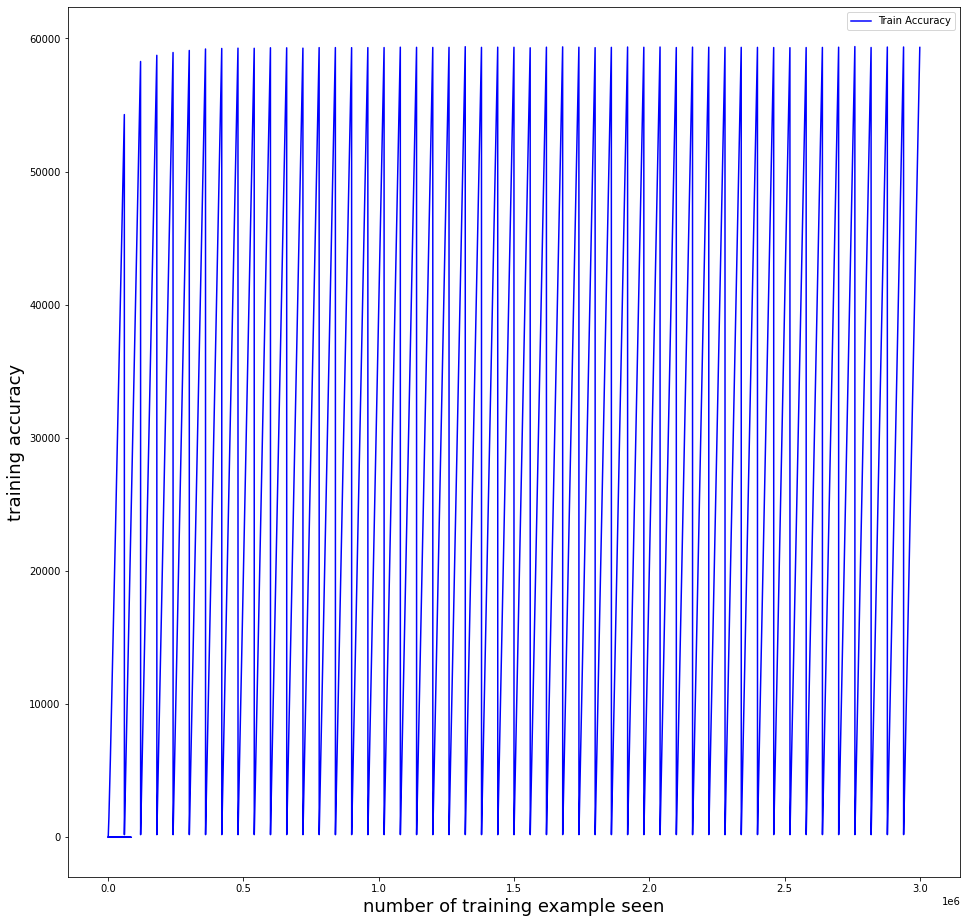

In [25]:
fig_train = plt.figure(figsize = (16,16))
plt.plot(train_count, train_correct, color = 'blue')
plt.legend(['Train Accuracy'], loc='upper right')
plt.xlabel('number of training example seen', fontsize=18)
plt.ylabel('training accuracy', fontsize=18)
plt.savefig('/content/gdrive/My Drive/train_plot.jpg')

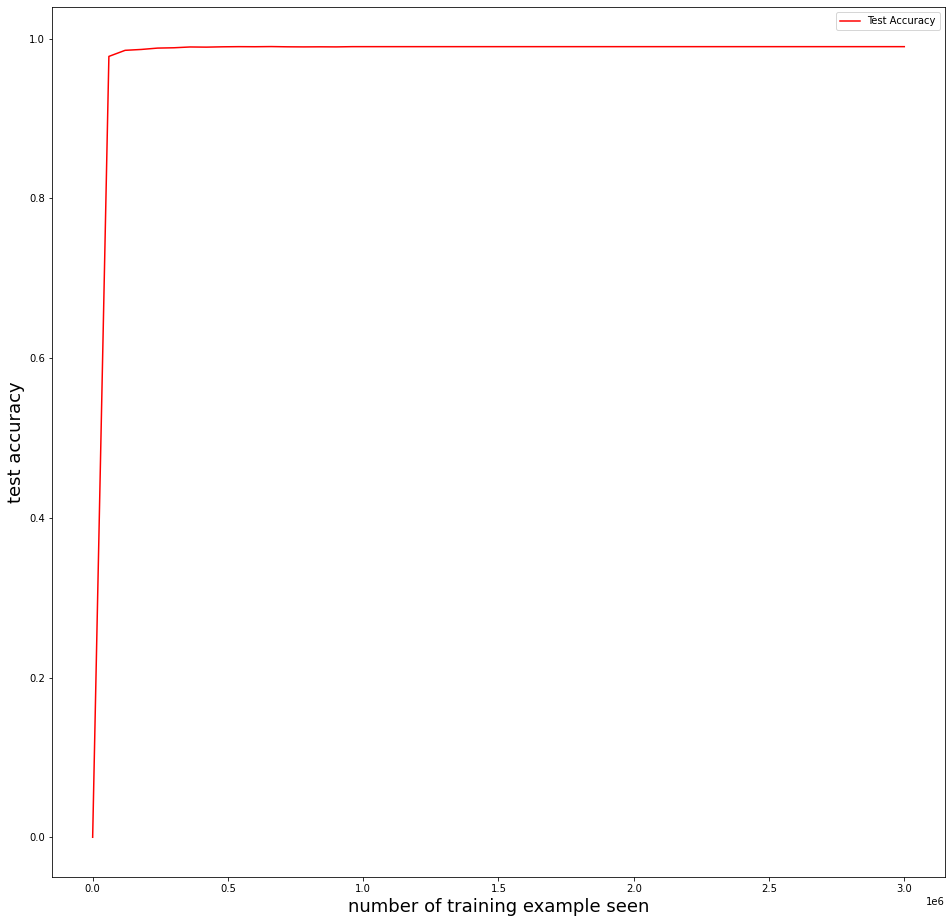

In [34]:
fig_test = plt.figure(figsize = (16,16))
plt.plot(test_count, test_correct, color = 'red')
plt.legend(['Test Accuracy'], loc='upper right')
plt.xlabel('number of training example seen', fontsize=18)
plt.ylabel('test accuracy', fontsize=18)
plt.savefig('/content/gdrive/My Drive/test_plot.jpg')